[100/300]	Loss_D: 0.9158	Loss_G: 7.0330


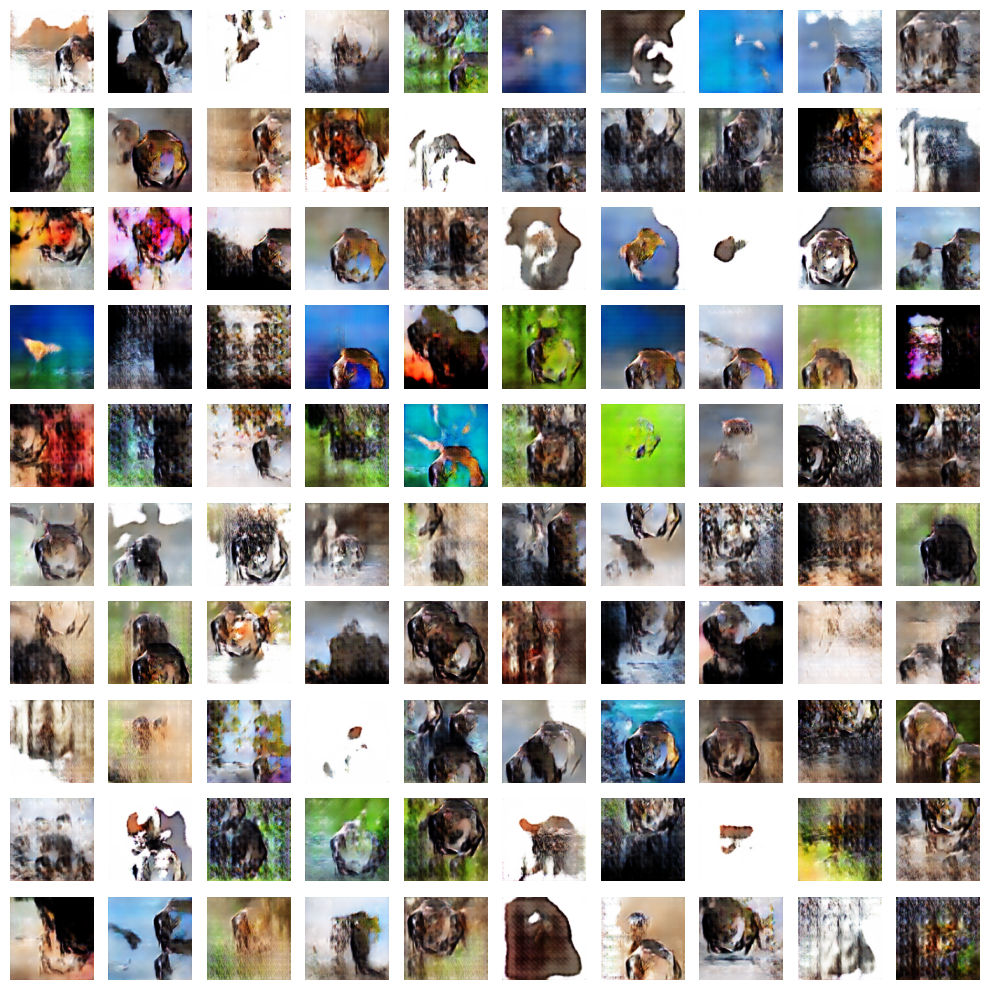

100%|██████████| 17/17 [00:02<00:00,  5.98it/s]


FID Score at epoch 100: 197.2060875272543
[200/300]	Loss_D: 0.4362	Loss_G: 4.0024


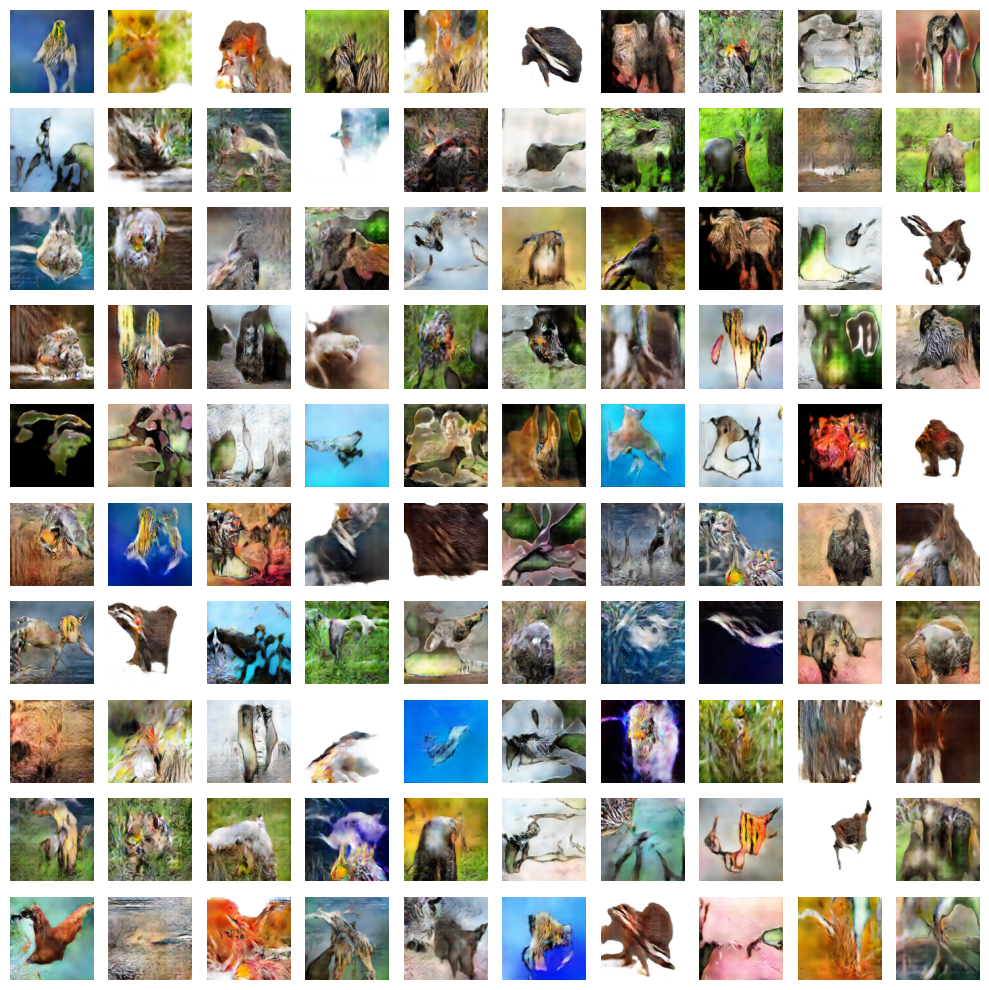

100%|██████████| 17/17 [00:02<00:00,  5.98it/s]


FID Score at epoch 200: 154.94827661122122
[300/300]	Loss_D: 0.1166	Loss_G: 5.9329


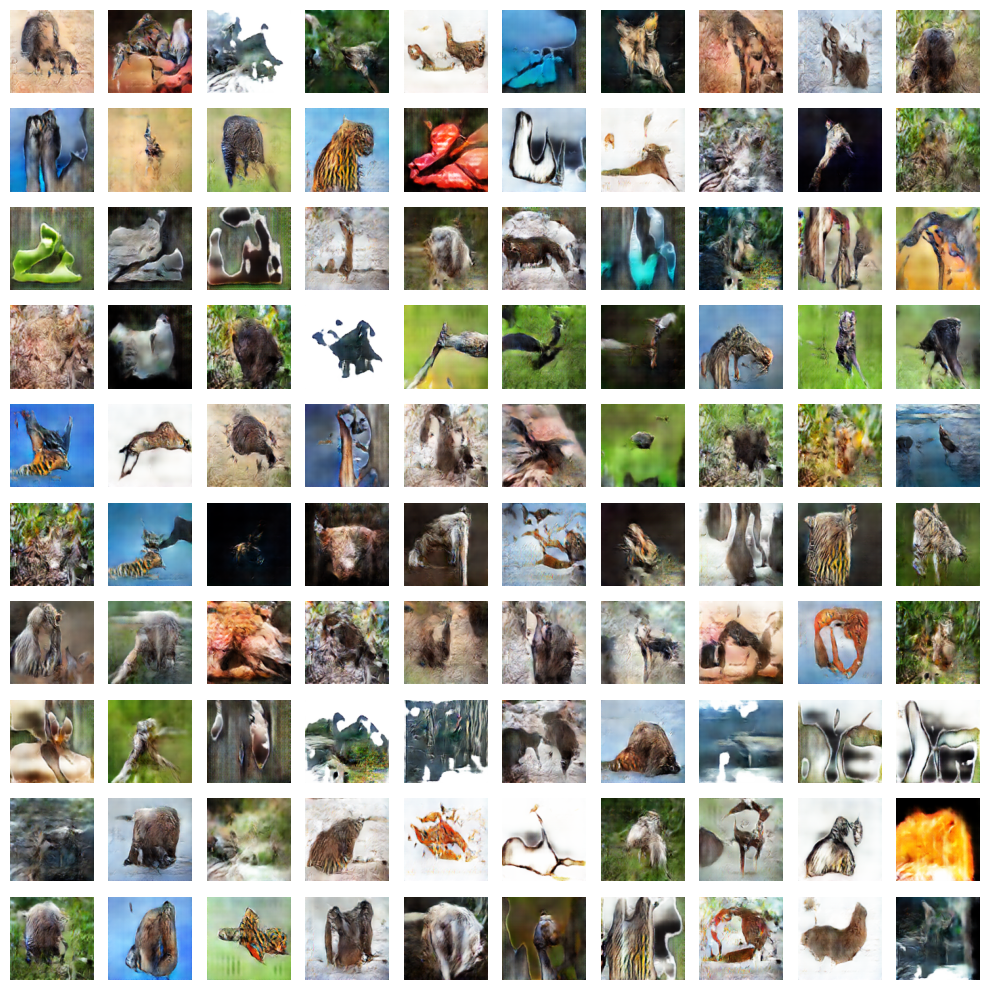

100%|██████████| 17/17 [00:02<00:00,  5.95it/s]


FID Score at epoch 300: 158.3972644131785


In [96]:
for epoch in range(params['num_epochs']):

    errorGs=[]
    errorDs=[]
    for i, data in enumerate(dataloader_animals):
        errorD_k=[]
        for k in range(params['k_d']):
            real_image = data[0].to(device)
            batch_size = real_image.size(0)
            netD.zero_grad()
            label = torch.full((batch_size, ), 1, device=device).float()
            output = netD(real_image).view(-1)
            errorD_real = criterion(output, label)
            errorD_real.backward()
            z = torch.randn(batch_size, params['dim_z'], 1, 1, device=device)
            fake_data = netG(z)
            label.fill_(0)
            output = netD(fake_data.detach()).view(-1)
            errorD_fake = criterion(output, label)
            errorD_fake.backward()
            errorD = errorD_real + errorD_fake
            optimizerD.step()
            errorD_k.append(errorD.item())
        errorD_k_avg=np.average(errorD_k)
        errorDs.append(errorD_k_avg)
        
        errorG_k=[]
        for k in range(params['k_g']): 
            netG.zero_grad()
            label.fill_(1)
            output = netD(fake_data).view(-1)
            errorG = criterion(output, label)
            errorG.backward()
            optimizerG.step()
            errorG_k.append(errorG.item())

        errorG_k_avg=np.average(errorG_k)
        errorGs.append(errorG_k_avg)

    # Save the losses for plotting.
    G_losses.append(np.average(errorDs))
    D_losses.append(np.average(errorGs))

    # Save the model.
    if (epoch+1) % params['save_epoch'] == 0:
        torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model_animals_epoch_{}.pth'.format(epoch+1))
    
    
    if (epoch+1) % 100 == 0: 
        netG.eval()
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch+1, params['num_epochs'], errorD.item(), errorG.item()))  
         
        z = torch.randn(100, params['dim_z'], 1, 1, device=device)
        with torch.no_grad():
            generated_img = netG(z).detach().cpu()

        fig, axs = plt.subplots(10, 10, figsize=(10, 10))

        for i in range(10):
            for j in range(10):
                img = generated_img[i * 10 + j].permute(1, 2, 0).detach().numpy()
                min_val = img.min()
                max_val = img.max()
                normalized_img = (img - min_val) / (max_val - min_val)
                
                # Plot the image
                axs[i, j].imshow(normalized_img)
                axs[i, j].axis('off')

        plt.tight_layout()
        plt.show()
        
        fid_value = calculate_fid_animals(netG,params)
        print(f"FID Score at epoch {epoch+1}: {fid_value}")
